# Natural Language Processing with IMDB

<br></br>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IMDB_Logo_2016.svg/800px-IMDB_Logo_2016.svg.png" alt="Rotten Tomatoes Logo" title="RT Logo" />

## Project Overview
> from https://www.kaggle.com/c/word2vec-nlp-tutorial

### Data Set
The labeled data set consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. In addition, there are another 50,000 IMDB reviews provided without any rating labels.

### File descriptions
- labeledTrainData - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 - - rows containing an id, sentiment, and text for each review.  
- testData - The test set. The tab-delimited file has a header row followed by 25,000 rows containing an id and text for each review. Your task is to predict the sentiment for each one. 
- unlabeledTrainData - An extra training set with no labels. The tab-delimited file has a header row followed by 50,000 rows containing an id and text for each review. 
- sampleSubmission - A comma-delimited sample submission file in the correct format.

### Data fields
- id - Unique ID of each review
- sentiment - Sentiment of the review; 1 for positive reviews and 0 for negative reviews
- review - Text of the review

# Notebook Contents
## Part I: Data Cleaning
## Part II:  Feature Generation
## Part III: Model Selection & Prediction

# Part I: Data Cleaning with Beautiful Soup

The data for each review is pulled from imdb as raw html. To make each review accessible for feature generation, the reviews must have their html components removed as well as filtered for stop word removal. After these data cleaning steps, the reviews will consist of meaningful words that can be processed with natural language methods.

In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline


In [6]:
train = pd.read_csv("datasets/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3,encoding='utf-8') 
test = pd.read_csv("datasets/testData.tsv", header=0, \
                    delimiter="\t", quoting=3,encoding='utf-8')

In [4]:
# inspecting training data
print train.isnull().any()
train.head()

id           False
sentiment    False
review       False
dtype: bool


,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [7]:
# inspecting test data
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [6]:
train['review'][0]

u'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finall

In [8]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print(": train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

: train : test
('rows   :', 25000, ':', 25000)
('perc   :', 50.0, '   :', 50.0)


In [9]:
print "number of rows for sentiment 1: {}".format(len(train[train.sentiment==1]))
print "number of rows for sentiment 0: {}".format(len(train[train.sentiment==0]))
#sentiments are equally split

number of rows for sentiment 1: 12500
number of rows for sentiment 0: 12500


In [10]:
print "no missing values in training set"
print train.isnull().sum()
print "\nno missing values in test set"
print test.isnull().sum()

no missing values in training set
id           0
sentiment    0
review       0
dtype: int64

no missing values in test set
id        0
review    0
dtype: int64


In [11]:
#concat both train and test
merge=pd.concat([train[['id','review']],test[['id','review']]])
df=merge.reset_index(drop=True)
print df.head()
df[df.id=='"12311_10"']
#df.iloc[25000:] is test set
#df.iloc[:25000] is train set

         id                                             review
0  "5814_8"  "With all this stuff going down at the moment ...
1  "2381_9"  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"  "The film starts with a manager (Nicholas Bell...
3  "3630_4"  "It must be assumed that those who praised thi...
4  "9495_8"  "Superbly trashy and wondrously unpretentious ...


,id,review
25000,"""12311_10""","""Naturally in a film who's main themes are of ..."


In [12]:
# Import BeautifulSoup into your workspace
# use beautiful soup to remove html tags
from bs4 import BeautifulSoup             

# Initialize the BeautifulSoup object on a single movie review     
example1 = BeautifulSoup(train["review"][0], 'lxml')  

# Print the raw review and then the output of get_text(), for 
# comparison
print example1.get_text()

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 20 mi

In [13]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'lxml').get_text() 
    #
    # 2. Remove non-letters with regex
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                           
    #
    # 4. Create set of stopwords
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   
#apply function to reviews
df['review_cleaned']=df['review'].apply(review_to_words)
df_justclean = df[['id','review_cleaned']]

# Part II: Feature Generation 
## FG: Descriptive Statistics About Word and Letter Properties 
In addition to the actual words in the reviews itself, it may be useful to generate features on metadata of each review. Word count, letter count, word length, and measures of uniqueness have the potential to help with model training alongside the n-grams that will be generated later.

In [20]:
## Descriptive Stats

#Word count in each comment:
df['count_word']=df["review_cleaned"].apply(lambda x: len(str(x).split()))
df['count_unique_word']=df["review_cleaned"].apply(lambda x: len(set(str(x).split())))#split creates groups
#Letter count
df['count_letters']=df["review_cleaned"].apply(lambda x: len(str(x)))
#Average length of the words
df["mean_word_len"] = df["review_cleaned"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [21]:
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']

In [22]:
#serperate train and test features
train_feats=df.iloc[0:len(train),] # zero to index of len train
test_feats=df.iloc[len(train):,] #len train to end
#join the tags
train_tags=train['sentiment']
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [23]:
train_feats.head()

,id,review,review_cleaned,count_word,count_unique_word,count_letters,mean_word_len,word_unique_percent,sentiment
0,"""5814_8""","""With all this stuff going down at the moment ...",stuff going moment mj started listening music ...,219,166,1421,5.493151,75.799087,1
1,"""2381_9""","""\""The Classic War of the Worlds\"" by Timothy ...",classic war worlds timothy hines entertaining ...,84,67,596,6.107143,79.761905,1
2,"""7759_3""","""The film starts with a manager (Nicholas Bell...",film starts manager nicholas bell giving welco...,240,213,1816,6.570833,88.750000,0
3,"""3630_4""","""It must be assumed that those who praised thi...",must assumed praised film greatest filmed oper...,189,163,1437,6.608466,86.243386,0
4,"""9495_8""","""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious explo...,210,192,1525,6.266667,91.428571,1


In [24]:
train_feats.describe()

,count_word,count_unique_word,count_letters,mean_word_len,word_unique_percent,sentiment
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,119.523560,98.016160,823.983320,5.850890,85.152944,0.50000
std,90.583576,66.541265,639.122189,0.408079,7.548668,0.50001
min,4.000000,4.000000,27.000000,4.214286,16.981132,0.00000
25%,63.000000,55.000000,426.000000,5.581395,80.376477,0.00000
50%,89.000000,76.000000,604.000000,5.847642,85.714286,0.50000
75%,146.000000,120.000000,1003.000000,6.114698,90.588235,1.00000
max,1416.000000,588.000000,9155.000000,8.636364,100.000000,1.00000


In [21]:
train_feats.quantile(0.8)

count_word              167.000000
count_unique_word       136.000000
count_letters          1154.000000
mean_word_len             6.185596
word_unique_percent      91.666667
sentiment                 1.000000
Name: 0.8, dtype: float64

In [25]:
# place bounds on descriptive stats
train_feats['count_word'].loc[train_feats['count_word']>150] = 150 # set columns with count sent longer than 90 to 90
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>136] = 136 # set columns with count sent longer than 90 to 90
train_feats['count_letters'].loc[train_feats['count_letters']>1154] = 1154

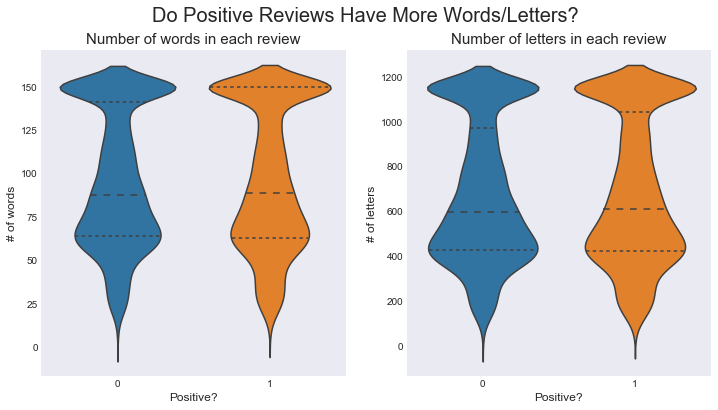

In [26]:
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Do Positive Reviews Have More Words/Letters?",fontsize=20)
sns.violinplot(y='count_word',x='sentiment', data=train_feats,split=True,inner="quart")
plt.xlabel('Positive?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each review", fontsize=15)
# words/set count of words longer than 200 to 200

plt.subplot(122)
sns.violinplot(y='count_letters',x='sentiment', data=train_feats,split=True,inner="quart")
plt.xlabel('Positive?', fontsize=12)
plt.ylabel('# of letters', fontsize=12)
plt.title("Number of letters in each review", fontsize=15)

plt.show()

#### Observation
There doesn't look like there's a difference in distribution among the two. Positive reviews have a slightly larger mean. A t-test could confirm that there's no significant difference between positive and negative reviews.

In [27]:
from scipy import stats
stats.ttest_ind(train_feats[train_feats.sentiment==0]['count_word'], train_feats[train_feats.sentiment==1]['count_word'], equal_var = False)

Ttest_indResult(statistic=-0.81305766046440264, pvalue=0.41619275774524234)

In [28]:
from scipy import stats
stats.ttest_ind(train_feats[train_feats.sentiment==0]['count_letters'], train_feats[train_feats.sentiment==1]['count_letters'], equal_var = False)

Ttest_indResult(statistic=-2.6572892648369386, pvalue=0.0078821985244819214)

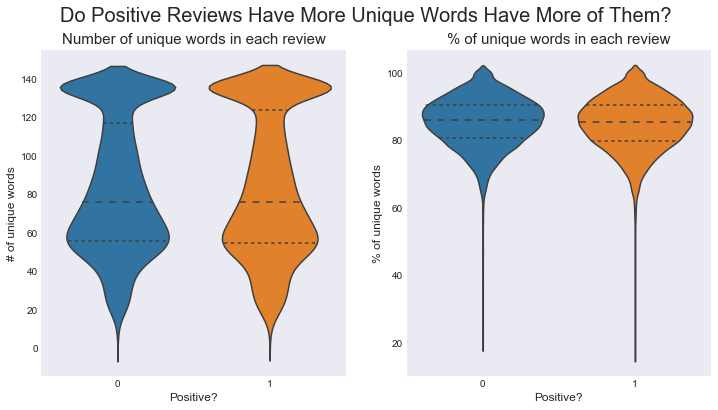

In [29]:
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Do Positive Reviews Have More Unique Words Have More of Them?",fontsize=20)
sns.violinplot(y='count_unique_word',x='sentiment', data=train_feats,split=True,inner="quart")
plt.xlabel('Positive?', fontsize=12)
plt.ylabel('# of unique words', fontsize=12)
plt.title("Number of unique words in each review", fontsize=15)
# words/set count of words longer than 200 to 200

plt.subplot(122)
sns.violinplot(y='word_unique_percent',x='sentiment', data=train_feats,split=True,inner="quart")
plt.xlabel('Positive?', fontsize=12)
plt.ylabel('% of unique words', fontsize=12)
plt.title("% of unique words in each review", fontsize=15)

plt.show()

In [30]:
print "t-stat for unique words"
print stats.ttest_ind(train_feats[train_feats.sentiment==0]['count_unique_word'], train_feats[train_feats.sentiment==1]['count_unique_word'], equal_var = False)
print "\nt-stat for % unique words"
print stats.ttest_ind(train_feats[train_feats.sentiment==0]['word_unique_percent'], train_feats[train_feats.sentiment==1]['word_unique_percent'], equal_var = False)

t-stat for unique words
Ttest_indResult(statistic=-0.50804279605865899, pvalue=0.6114278233590944)

t-stat for % unique words
Ttest_indResult(statistic=5.6865284878324491, pvalue=1.3109782597794204e-08)


#### Observation
Significant variables are word_unique_percent, count_word, count_letters, with word_unique being the strongest, meaning that writers of negative reviews might tend to be more imaginative with word use.

In [31]:
# looking at negative reviews
train_feats[train_feats.sentiment==0].describe()

,count_word,count_unique_word,count_letters,mean_word_len,word_unique_percent,sentiment
count,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.0
mean,95.657280,83.689280,676.742400,5.811183,85.424260,0.0
std,39.618013,35.184703,312.424164,0.395832,7.326485,0.0
min,4.000000,4.000000,27.000000,4.333333,20.000000,0.0
25%,64.000000,56.000000,427.000000,5.550994,80.769231,0.0
50%,88.000000,76.000000,598.000000,5.805310,86.029412,0.0
75%,141.000000,117.000000,970.000000,6.064396,90.647482,0.0
max,150.000000,136.000000,1154.000000,8.307692,100.000000,0.0


In [32]:
train_feats[train_feats.word_unique_percent>90]['review_cleaned'][4].encode('utf-8')

'superbly trashy wondrously unpretentious exploitation hooray pre credits opening sequences somewhat give false impression dealing serious harrowing drama need fear barely ten minutes later necks nonsensical chainsaw battles rough fist fights lurid dialogs gratuitous nudity bo ingrid two orphaned siblings unusually close even slightly perverted relationship imagine playfully ripping towel covers sister naked body stare unshaven genitals several whole minutes well bo sister judging dubbed laughter mind sick dude anyway kids fled russia parents nasty soldiers brutally slaughtered mommy daddy friendly smuggler took custody however even raised trained bo ingrid expert smugglers actual plot lifts years later facing ultimate quest mythical incredibly valuable white fire diamond coincidentally found mine things life ever made little sense plot narrative structure white fire sure lot fun watch time clue beating cause bet actors understood even less whatever violence magnificently grotesque eve

In [33]:
train_feats.rename(columns={"sentiment": "target_sentiment"},inplace=True)

In [34]:
train_feats.head()

,id,review,review_cleaned,count_word,count_unique_word,count_letters,mean_word_len,word_unique_percent,target_sentiment
0,"""5814_8""","""With all this stuff going down at the moment ...",stuff going moment mj started listening music ...,150,136,1154,5.493151,75.799087,1
1,"""2381_9""","""\""The Classic War of the Worlds\"" by Timothy ...",classic war worlds timothy hines entertaining ...,84,67,596,6.107143,79.761905,1
2,"""7759_3""","""The film starts with a manager (Nicholas Bell...",film starts manager nicholas bell giving welco...,150,136,1154,6.570833,88.750000,0
3,"""3630_4""","""It must be assumed that those who praised thi...",must assumed praised film greatest filmed oper...,150,136,1154,6.608466,86.243386,0
4,"""9495_8""","""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious explo...,150,136,1154,6.266667,91.428571,1


## FG: Corpus Cleaning and Generating N-Grams using TfidfVectorizer

In [35]:
#Corpus cleaning: Its important to use a clean dataset before creating count features.
merge['cleaned_review']=merge['review'].apply(review_to_words)
corpus = merge.cleaned_review
#dictionary of apostrophe words
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

In [36]:
#Extending the CountVectorizer class with a lemmatizer (turning word forms into their based root)
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
#takes the CountVectorizer() function and replaces the .build_analyzer() method with lemmacountvectorizer

#tf = tf_vectorizer.fit_transform(text)

In [37]:
def clean(comment):

    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word,"v") for word in words] #lemmatizes based on position v
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [38]:
# demonstrates of cleaning
clean(corpus.iloc[0])

u'stuff go moment mj start listen music watch odd documentary watch wiz watch moonwalker maybe want get certain insight guy think really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember go see cinema originally release subtle message mj feel towards press also obvious message drug bad kay visually impressive course michael jackson unless remotely like mj anyway go hate find bore may call mj egotist consent make movie mj fan would say make fan true really nice actual feature film bite finally start minutes exclude smooth criminal sequence joe pesci convince psychopathic powerful drug lord want mj dead bad beyond mj overhear plan nah joe pesci character rant want people know supply drug etc dunno maybe hat mj music lot cool things like mj turn car robot whole speed demon sequence also director must patience saint come film kiddy bad sequence usually directors hate work one kid let alone whole bunch perform complex dance scene bott

In [39]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

('total time till Cleaning', 9261.08992099762)


In [40]:
clean_corpus.head()

0    stuff go moment mj start listen music watch od...
1    classic war worlds timothy hines entertain fil...
2    film start manager nicholas bell give welcome ...
3    must assume praise film greatest film opera ev...
4    superbly trashy wondrously unpretentious explo...
Name: cleaned_review, dtype: object

In [48]:
clean_corpus[:len(train_feats)]

25000

In [57]:
# Import necessary modules // https://stackoverflow.com/questions/44066264/how-to-choose-parameters-in-tfidfvectorizer-in-sklearn-during-unsupervised-clust
# optimize vectorizer parameters
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xg

X=clean_corpus[:len(train_feats)]
Y=train_feats['target_sentiment']

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000,strip_accents='unicode', analyzer='word')),
    ('clf', xg.XGBClassifier(n_estimators=900,learning_rate=0.1))
])
parameters = {
    'tfidf__max_df': np.arange(0.75,0.95,.05),
    'tfidf__min_df': np.arange(0.01,0.10,.02),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

grid_search_tune = RandomizedSearchCV(pipeline, parameters, cv=StratifiedKFold(5), n_jobs=-1, verbose=3,scoring='accuracy',n_iter=30)
grid_search_tune.fit(X, Y)

print("Tuned SGD Parameters: {}".format(grid_search_tune.best_params_))
print("Best score is {}".format(grid_search_tune.best_score_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 2), tfidf__min_df=0.01 
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 2), tfidf__min_df=0.01 
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 2), tfidf__min_df=0.01 
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 2), tfidf__min_df=0.01 
[CV]  tfidf__max_df=0.9, tfidf__ngram_range=(1, 2), tfidf__min_df=0.01, score=0.8474, total= 5.7min
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 2), tfidf__min_df=0.01 
[CV]  tfidf__max_df=0.9, tfidf__ngram_range=(1, 2), tfidf__min_df=0.01, score=0.8524, total= 5.7min
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 1), tfidf__min_df=0.05 
[CV]  tfidf__max_df=0.9, tfidf__ngram_range=(1, 2), tfidf__min_df=0.01, score=0.8504, total= 5.7min
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 1), tfidf__min_df=0.05 
[CV]  tfidf__max_df=0.9, tfidf__ngram_range=(1, 2), tfidf__min_df=0.01, score=0.858, total= 5.7min
[CV] tfidf__max_df=0.9, tfidf__ngram_range

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 21.8min


[CV] tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.09 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 1), tfidf__min_df=0.09, score=0.7292, total= 1.7min
[CV] tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.09 
[CV]  tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.09, score=0.738, total= 2.8min
[CV] tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.09 
[CV]  tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.09, score=0.745, total= 2.8min
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 1), tfidf__min_df=0.03 
[CV]  tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.09, score=0.7346, total= 2.9min
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 1), tfidf__min_df=0.03 
[CV]  tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.09, score=0.7384, total= 2.9min
[CV] tfidf__max_df=0.9, tfidf__ngram_range=(1, 1), tfidf__min_df=0.03 
[CV]  tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.

[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 2), tfidf__min_df=0.07 
[CV]  tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.03, score=0.8214, total= 4.5min
[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 2), tfidf__min_df=0.07 
[CV]  tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.03, score=0.8376, total= 4.4min
[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 2), tfidf__min_df=0.07 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 2), tfidf__min_df=0.07, score=0.7716, total= 2.5min
[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 2), tfidf__min_df=0.07 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 2), tfidf__min_df=0.07, score=0.7682, total= 2.5min
[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 2), tfidf__min_df=0.07 
[CV]  tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), tfidf__min_df=0.03, score=0.8292, total= 4.4min
[CV] tfidf__max_df=0.85, tfidf__ngram_range=(1, 2), tfidf__min_df=0.05 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 2), tfidf__min_df=0.07

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 106.2min


[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 3), tfidf__min_df=0.01 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 3), tfidf__min_df=0.01, score=0.8474, total= 5.8min
[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 3), tfidf__min_df=0.01 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 3), tfidf__min_df=0.01, score=0.8524, total= 5.9min
[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 1), tfidf__min_df=0.05 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 3), tfidf__min_df=0.01, score=0.8504, total= 5.9min
[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 1), tfidf__min_df=0.05 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 3), tfidf__min_df=0.01, score=0.858, total= 5.9min
[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 1), tfidf__min_df=0.05 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 1), tfidf__min_df=0.05, score=0.81, total= 2.6min
[CV] tfidf__max_df=0.8, tfidf__ngram_range=(1, 1), tfidf__min_df=0.05 
[CV]  tfidf__max_df=0.8, tfidf__ngram_range=(1, 1), tfidf__min_df=0.05, score

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 136.5min finished


Tuned SGD Parameters: {'tfidf__max_df': 0.90000000000000013, 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 0.01}
Best score is 0.85252


In [67]:
# create vectorizer
tf_vectorizer = TfidfVectorizer(max_df=0.90,min_df=0.001,  max_features=5000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tf = tf_vectorizer.fit_transform(clean_corpus)

In [68]:
features=np.array(tf_vectorizer.get_feature_names())
print features
print len(features)

[u'aaron' u'abandon' u'abc' ..., u'zombie' u'zombies' u'zone']
5000


In [69]:
df_12g = pd.DataFrame(tf.toarray(),columns=features)
df_12g.head()

,aaron,abandon,abc,abilities,ability,able,absence,absent,absolute,absolutely,...,young girl,young man,young people,young woman,younger,youth,zero,zombie,zombies,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


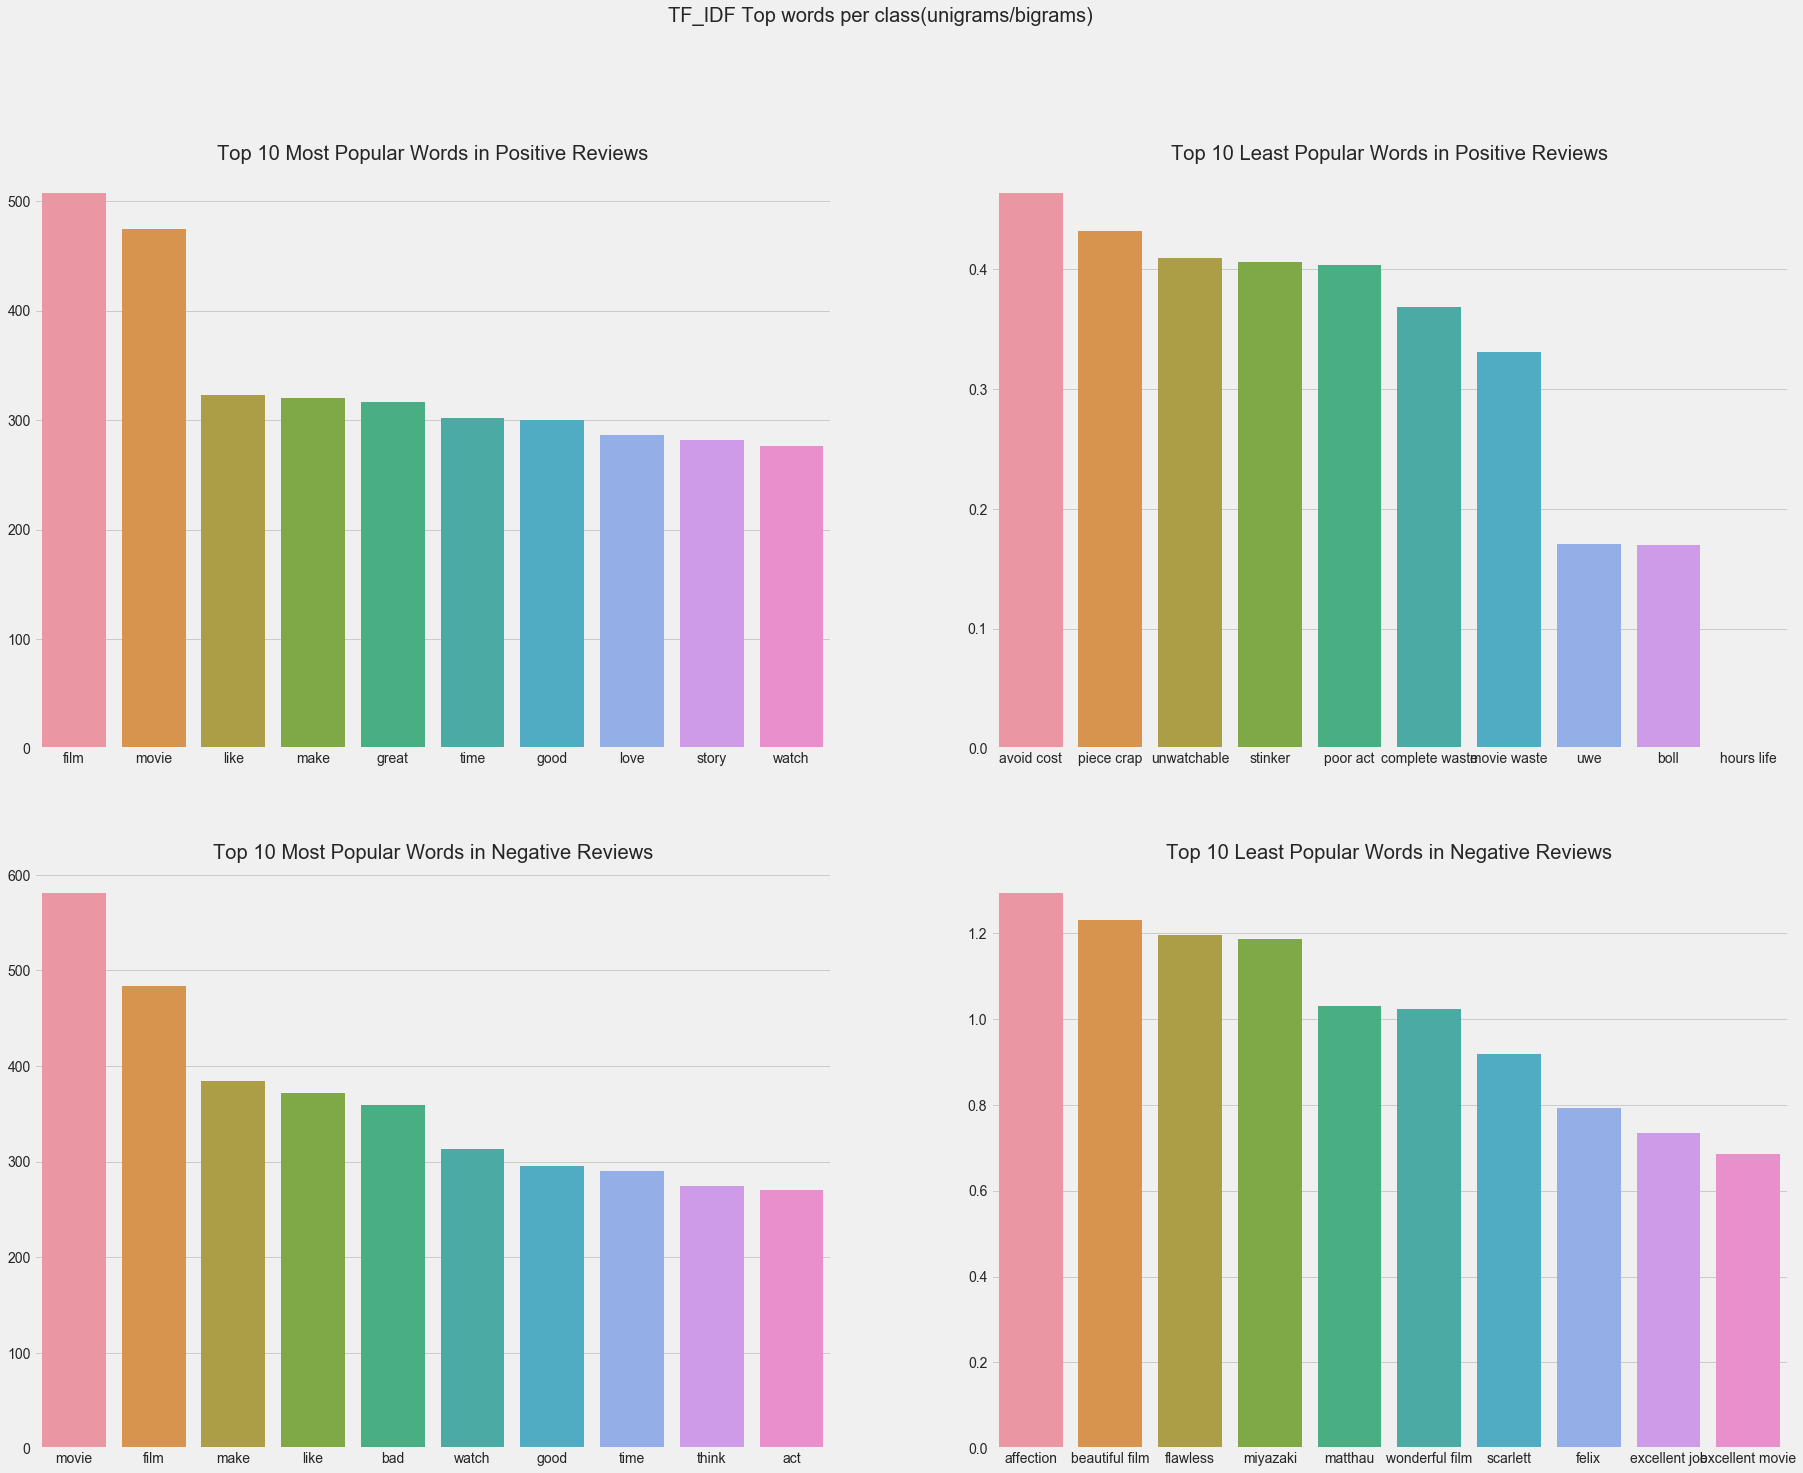

In [97]:
# graph most popular 1,2 grams
df_12g_train=pd.concat([train_feats['target_sentiment'],df_12g.iloc[:len(train_feats),:]],axis=1)
df_12g_test=df_12g.iloc[len(train_feats):,:]
# concat train with sentiment
# most popular/least popular for positive reviews
top10_pos=np.sum(df_12g_train[df_12g_train.target_sentiment==1].iloc[:,1:]).sort_values(ascending=False).head(10)
last10_pos=np.sum(df_12g_train[df_12g_train.target_sentiment==1].iloc[:,1:]).sort_values(ascending=False).tail(10)
# most popular/least popular for negative reviews
top10_neg=np.sum(df_12g_train[df_12g_train.target_sentiment==0].iloc[:,1:]).sort_values(ascending=False).head(10)
last10_neg=np.sum(df_12g_train[df_12g_train.target_sentiment==0].iloc[:,1:]).sort_values(ascending=False).tail(10)

#tokenizer counts number of instances per word. for instance review zero has 3 counts of film
plt.style.use('fivethirtyeight')
plt.figure(figsize=(28,22))
plt.suptitle("TF_IDF Top words per class(unigrams/bigrams)",fontsize=20)
plt.subplot(221)
plt.title("Top 10 Most Popular Words in Positive Reviews")
sns.barplot(top10_pos.index,\
            top10_pos)

plt.subplot(222)
plt.title("Top 10 Least Popular Words in Positive Reviews")
sns.barplot(last10_pos.index,\
            last10_pos)

plt.subplot(223)
plt.title("Top 10 Most Popular Words in Negative Reviews")
sns.barplot(top10_neg.index,\
            top10_neg)

plt.subplot(224)
plt.title("Top 10 Least Popular Words in Negative Reviews")
sns.barplot(last10_neg.index,\
            last10_neg)

In [108]:
merged_desc_12g=pd.concat([df[['id','count_word','count_unique_word','count_letters','mean_word_len','word_unique_percent']],df_12g],axis=1)
merged_desc_12g.to_csv('datasets/merged_desc_12g.csv',index=False)